# DYNAMIC MODELS FOR BUILDING ENERGY MANAGEMENT

Group members
1. Tannous Maroun
2. Bell Emily
3. Bicudo Bregion Beatriz
4. Abdelkarim Aya

June 2nd of 2023

# MODEL

## Apartment sizing

The apartment analyzed is in the following figure and contains 2 rooms, which are linked by a door. Each room contains a window and room 1 also contains a door\
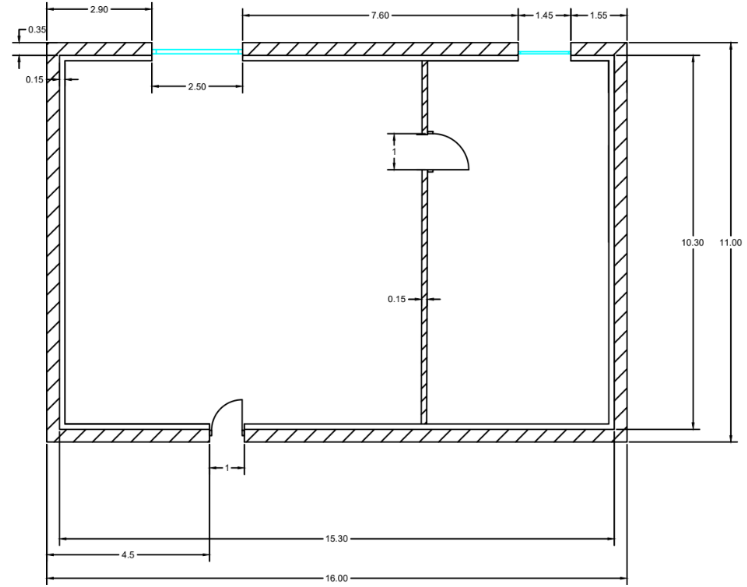

The thermal model diagram is in the following:

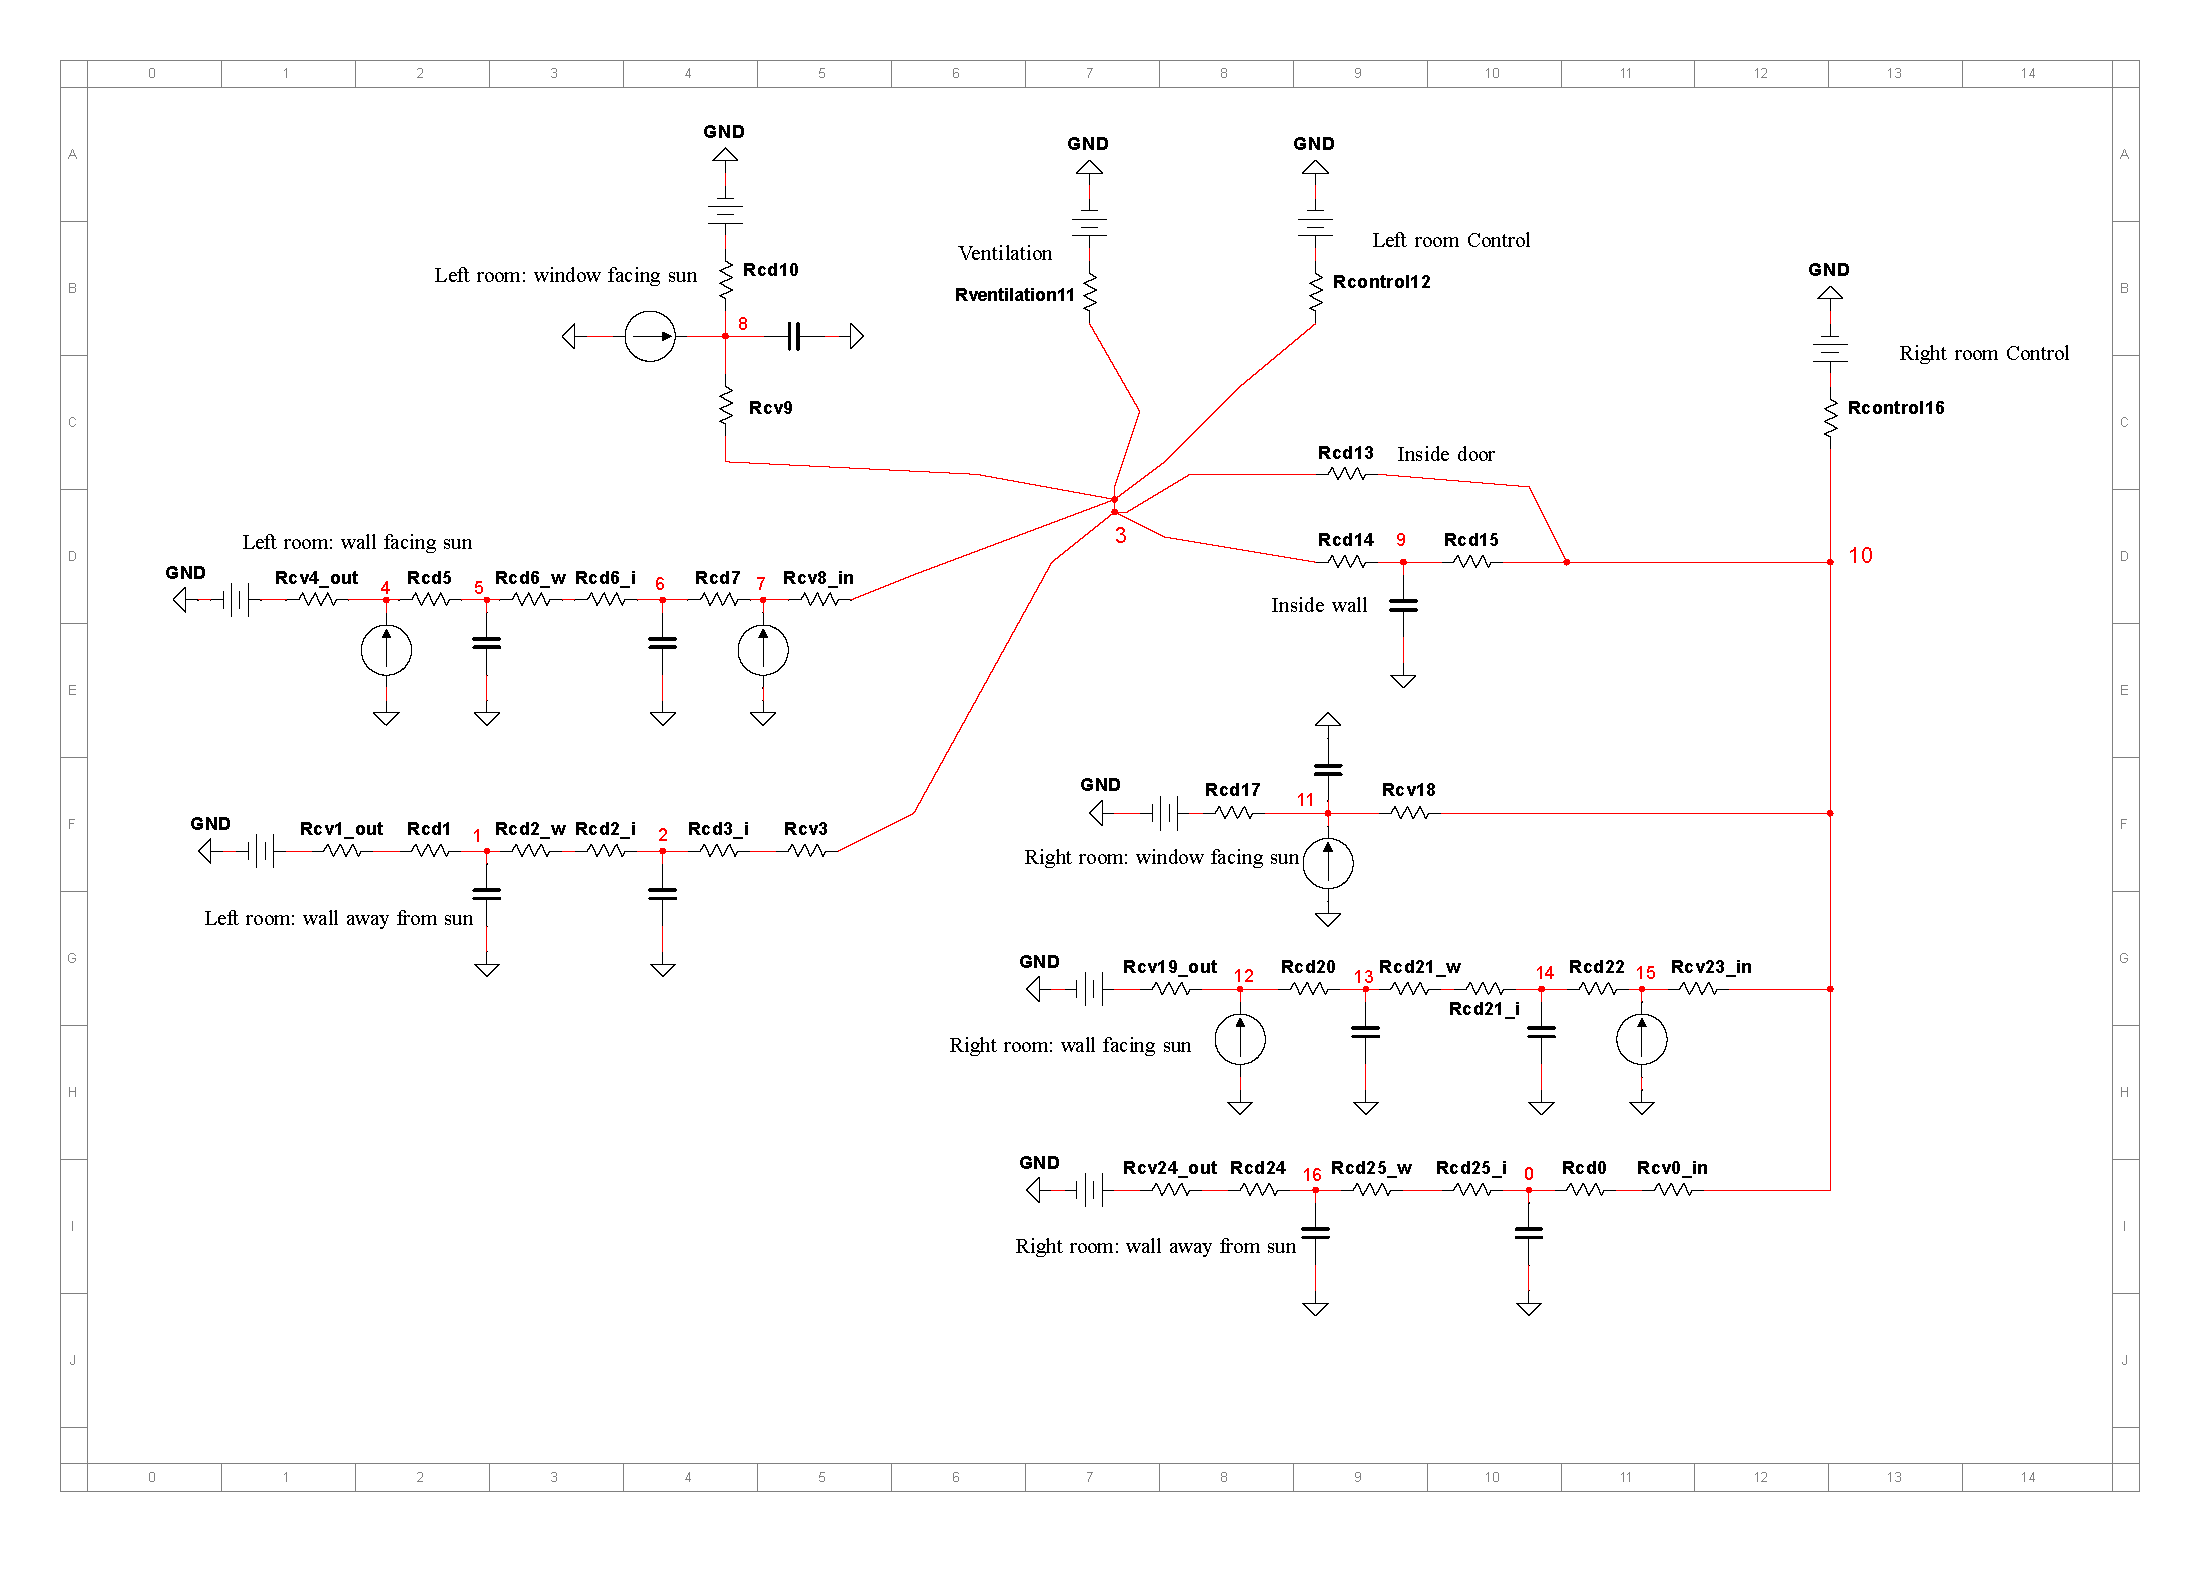

## Boundary conditions

- The thermal capacity of the windows, the convective heat transfer through the windows, as well as any radiant heat exchange between the walls themselves and between the windows and the walls were neglected
- The door between the toilet and the office room is open 
- The windows and the entrance’ door were closed during the simulation so the door is considered to be part of the wall, but the window is still taken separately
- It is assumed the sun is to the upper left hand corner of the floorplan, and so the sun is incident only on the upper and left hand walls
- This apartment is thermally isolated so there is no heat transfer through the floor or ceiling
- The indoor air’s temperature is homogenous
- The heat transfer is linear

## Choosing of materials

- Window\
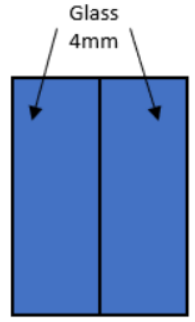
 
- External wall\
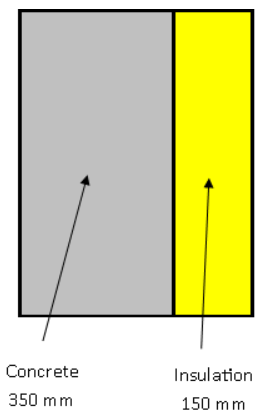

- Internal wall\
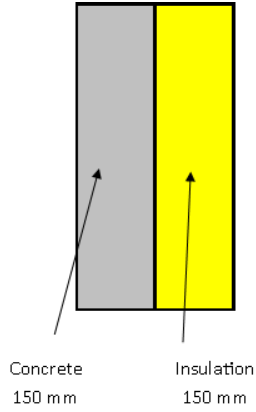


## Thermal model


### Calculation of conductances and capacities


| Material | Thickness (mm)   | Density (kg/m³) | Thermal conductivity (W/mK) | Specific heat (J/kgC) | Convection coefficient (W/m²K) |
| ----- | ----- | ----- | ----- | ----- | ----- |
| Glass | 4 | 2500 | 1.05 | 840 | 15 |
| Air (20 C) | 12 | 1.204 | 0.025 | 1000 | 50 |
| Concrete (external) | 350 | 2300 | 1.4 | 880 | 10 |
| Concrete (internal) | 150 | 2300 | 1.4 | 880 | 10 |
| Mineral fibre insulation | 150 | 20 | 0.035 | 1030 | 20 |
| Wood (oak) | 40 | 750 |0.17 | 2380 | 10 |

From these values, the thermal conductances and capacities can be calculated.

|Quantity |Equation|
| ----- | ----- | 
| Thermal conductance, conduction | Gcond = \frac {1}{Rcond} = \frac {\lambda \cdot S}{w} |
| Thermal conductance, convection | $Gconv=\frac{1}{Rconv}=h \cdot S$ |
| Thermal conductance, radiation | $Grad=\frac{1}{Rrad}=h \cdot S$ where $h \cdot r=\sigma \cdot \epsilon \cdot(Ts-Te) \cdot(Ts^2+T2^2)$ |
| Thermal conductance, advection | $Gadv= \rho \cdot c \frac{dV}{dt}$ |
| Thermal capacity | $C=c\cdot w \cdot S \cdot \rho$ |

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import dm4bem

w_glass=0.02
w_cocncrete_ex=0.35
w_concrete_int=0.15
w_insulation=0.15
w_oak=0.04
lambda_air=0.025
lambda_concrete=1.4
lambda_insulation=0.035
lambda_oak=0.7
lambda_glass=1.05
h_glass=15
h_air=50
h_concrete=10
h_insulation=20
h_oak=10
height=2.4
density_concrete=2300
density_glass=2500
density_insulation=20
density_oak=750
cp_glass=840
cp_concrete=880
cp_insulation=1030
cp_oak=2380
n=10 # time steps
wall_surface_sun=23.05
glass_surface_sun=3.95
α_wSW=0.2
τ_gSW=0.85
α_gSW=0.01


Va = height*10.3*9.85                   # m³, volume of air
ACH = 1                     # air changes per hour
Va_dot = ACH / 3600 * Va    # m³/s, air infiltration
# ventilation & advection
Gv = 1.204 * 1000 * Va_dot

# P-controler gain
Kp = 1e4            # almost perfect controller Kp -> ∞
#Kp = 1e-3           # no controller Kp -> 0
#Kp = 0

ModuleNotFoundError: ignored

## System of algebraic-differential equations (DAE)

In order to analyse the thermal circuit, the value of temperatures in the nodes,$\theta$ and the value of the heat flows on the branches q are required. To solve this problem, the following differential algebraic system of equations involving q and $\theta$ was applied:

$C \cdot \theta’$ = $-A^TGA\theta$ + $A^TGb + f$\
$q = G\cdot (-A\theta +b)$

Where A, C, G, b et f are matrices which will be described in the next section. Due to the number of nodes and branches, it was not feasible to manually write all the matrices, so instead a description of the structure of each matrix is given below.

### Matrices and inputs for the DAE model

Due to the number of nodes and branches, it was not feasible to manually write all the matrices, so instead a description of the structure of each matrix is given below.

#### Construction of matrix A

The incidence matrix, A, is a matrix that describes the topology of the network. It has dimensions m x n, where m is the number of branches (conductances) in the network and n is the number of nodes (unknown temperatures). The elements of the matrix are given by:

- A_ij = -1, if edge j leaves node i
- A_ij = 1, if edge j enters node i
- A_ij = 0, otherwise

In [ ]:
A = np.zeros([26, 17])       # n° of branches X n° of nodes
A[0, 0], A[0,10] = -1,1                 # branch 0: <- node 0
#A[1, 1] = -1    # branch 1: node 0 -> node 1
A[1, 1] = 1    # branch 1: node 0 -> node 1
A[2, 1], A[2, 2] = -1, 1    # branch 2: node 1 -> node 2
A[3, 2], A[3, 3] = -1, 1    # branch 3: node 2 -> node 3
A[4, 4] = 1    # branch 4: node 3 -> node 4
A[5, 4], A[5, 5] = -1, 1    # branch 5: node 4 -> node 5
#A[6, 4], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
A[6, 5], A[6, 6] = -1, 1    # branch 6: node 4 -> node 6
#A[7, 5], A[7, 6] = -1, 1    # branch 7: node 5 -> node 6
#A[7, 5], A[7, 6] = -1, -1    # branch 7: node 5 -> node 6
A[7,6]=-1 ##
A[7,7]=1
A[8, 7],A[8,3] = -1,1                 # branch 8: -> node 7
A[9, 8], A[9, 3] = -1, 1    # branch 9: node 5 -> node 7
A[10, 8] = 1                # branch 10: -> node 6
A[11, 3] = 1
A[12,3]=1# branch 11: -> node 6
A[13,3], A[13,10]=-1,1
A[14,3],A[14,9]=-1,1
A[15,9], A[15,10]=-1,1
A[16,10]=1
A[17,11]=1
A[18,10],A[18,11]=1,-1
A[19,12]=1
A[20,12]=-1
A[20,13]=1
A[21,13]=-1
A[21,14]=1
A[22,14],A[22,15]=-1,1
A[23,15],A[23,10]=-1,1
A[24,16], A[25,16],A[25,0]=1,-1,1

#### Construction of matrix G

The conductance matrix, G, is a diagonal matrix of size m x m (no. conductances square matrix), with the values on the diagonal being the sum of the conductances in that branch.

In [ ]:
#Divide by 2 everywhere
#we have divided the app to two rooms: left room facing sun: upper wall-window+left wall=4.95+2.9+11=18.85
#bottom wall of the left room not facing sun: 10.47
#right room upper wall facing sun: 1.55+7.6-4.95=4.2
# right room buildings no sun: 11+5.53=16.53
G=np.zeros([26,26])
G[0,0]=2*lambda_concrete*height*16.53/w_cocncrete_ex+h_concrete*height*16.53
G[1,1]=lambda_concrete*height*10.47/w_cocncrete_ex+h_concrete*height*10.47
G[2,2]=lambda_concrete*height*10.47/w_cocncrete_ex+lambda_insulation*height*10.47/w_insulation
G[3,3]=lambda_insulation*height*10.47/w_insulation+h_insulation*height*10.47
G[4,4]=h_concrete*height*18.85
G[5,5]=lambda_concrete*height*18.85/w_cocncrete_ex
G[6,6]=lambda_concrete*height*18.85/w_cocncrete_ex+lambda_insulation*height*18.85/w_insulation
G[7,7]=lambda_concrete*height*18.85/w_cocncrete_ex
G[8,8]=h_insulation*height*18.85
G[9,9]=h_glass*height*2.5
G[10,10]=lambda_glass*height*2.5
G[11,11]=Gv
G[12,12]=Kp #perfect controller
G[13,13]=lambda_oak*height*1
G[14,14]=lambda_concrete*height*10.3/w_concrete_int+h_concrete*height*10.3
G[15,15]=lambda_concrete*height*10.3/w_concrete_int+h_concrete*height*10.3
G[16,16]=Kp
G[17,17]=lambda_glass*height*1.45
G[18,18]=h_glass*height*1.45
G[19,19]=h_concrete*height*5.65
G[20,20]=lambda_concrete*height*5.65/w_cocncrete_ex
G[21,21]=lambda_concrete*height*5.65/w_cocncrete_ex+lambda_insulation*height*5.65/w_insulation
G[22,22]=lambda_concrete*height*5.65/w_cocncrete_ex
G[23,23]=h_insulation*height*5.65
G[24,24]=lambda_concrete*height*16.53/w_cocncrete_ex+h_concrete*height*16.53
G[25,25]=lambda_concrete*height*16.53/w_cocncrete_ex+lambda_insulation*height*16.53/w_insulation

NameError: ignored

#### Construction of matrix C
The capacity matrix, C, is a diagonal matrix of size n x n (in this case 17x17). where the values are the capacities as calculated using the previously stated equation. Based on the properties of each material used and in order to calculate the capacity of each element (window, external and internal walls), the equation $C = Cp \cdot \rho \cdot heght\cdot width \cdot A$, where Cp is thes pecific heat (J/kgC), $\rho$  is the density of the material(kg/m³) and A the surface change area 

In [ ]:
#Capacties
#Matrix C
C=np.zeros([17,17])
C[1,1]=cp_concrete*density_concrete*height*w_cocncrete_ex*10.47
C[2,2]=cp_insulation*density_insulation*height*w_insulation*10.47
C[5,5]=cp_concrete*density_concrete*height*w_cocncrete_ex*18.85
C[6,6]=cp_insulation*density_insulation*height*w_insulation*18.85
C[8,8]=cp_glass*density_glass*height*w_glass*2.5
C[9,9]=cp_oak*density_oak*height*w_oak
C[8,8]=cp_glass*density_glass*height*w_glass*1.45
C[13,13]=cp_concrete*density_concrete*height*w_cocncrete_ex*5.65
C[14,14]=cp_insulation*density_insulation*height*w_insulation*5.65
C[16,16]=cp_concrete*density_concrete*height*w_cocncrete_ex*16.53
C[0,0]=cp_insulation*density_insulation*height*w_insulation*16.53

#### Construction of vector b

The temperature source input is vector b, of length m (26), containing all the known temperatures. To each branch without source it was associated with a value of 0 in the vector b.

In [ ]:
b=np.zeros([26])
b[[1,4,10,11,12,16,17,19,24]]=1

#### Construction of vector f

Vector f is a vector of length n (in this case 17) containing all the known flow rates at each node. A node without a heat source was associated with a value of 0 in the f vector’s element of the f vector and a node which contains flow rate sources was associated with a value of 1 in the f vector.

In [ ]:
f=np.zeros([17])
f[[4,7,8,11,12,15]]=1

#### Construction of vector y

The output vector y, of length n (in this case 17), indicates which nodes correspond to the output of the models and which do not. In this vector, the nodes for which the temperatures are outputs are noted by 1 and if the temperature is not an output, the node is given by 0.

In [ ]:
y=np.zeros([17])
y[[3,10]]=1

### State-space representation

The differential algebraic system of equation seen in the section before can be transformed into state space representation as shown in the following system:

${\theta}' = A_{s}\theta _{S}+ B_{s}u$\
$y = C_{s}\theta _{S}+ D_{s}u$

where As, Bs, Cs, Ds and y are calculated using the function developed in the previous section.

In [ ]:
[As, Bs, Cs, Ds] = dm4bem.tc2ss(A, G, b, C, f, y)
print('As = \n', As, '\n')
print('Bs = \n', Bs, '\n')
print('Cs = \n', Cs, '\n')
print('Ds = \n', Ds, '\n')

# Steady-state response

### Calculate steady-state response of the system of Differential Algebraic Equations (DAE)

The aim of DAE is to solve the system of equations to find theta and q, the temperatures of the nodes and heat flows in the branches respectively.

$C \cdot \theta’$ = $-A^TGA\theta$ + $A^TGb + f$\
$q = G \cdot (-A \cdot \theta + b)$

To evaluate the steady state response, the outdoor temperature sources on the thermal diagram were set to 10 degrees, and the indoor temperature and HVAC temperature set to 20 degrees (vector b). The flow rate (vector f) was taken to be zero in all branches.

From this, theta and q could be calculated.

In the resulting output, it is assumed that negative values are due to the fact that flow is going in the opposite direction than was first assumed.

In [ ]:
b=np.zeros([26]) # temperature sources
b[[1,4,10,17,19,24]]=10 # outdoor temperature
b[[11,12,16]] = 20            # indoor set-point temperature

f = np.zeros(17)         # flow-rate sources

θ = np.linalg.inv(A.T @ G @ A) @ (A.T @ G @ b + f)
print(f'θ = {θ} °C')
q = G @ (-A @ θ + b)
print(f'q = {q} W')

NameError: ignored

### Obtain the steady-state response of the state-space representation

The state space representation, As Bs Cs Ds, was previously obtained from the system of DAE.

**As**\
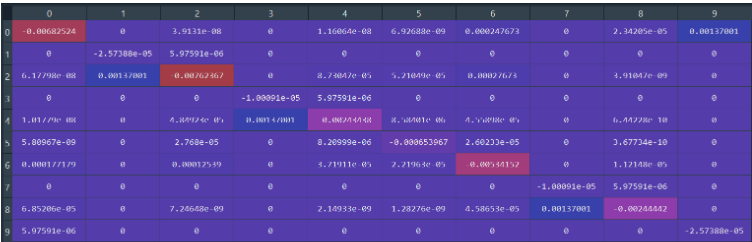

**Bs**\
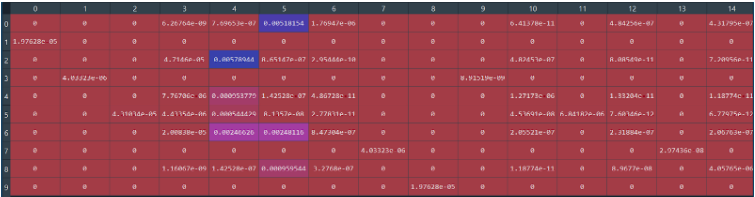

**Cs**\
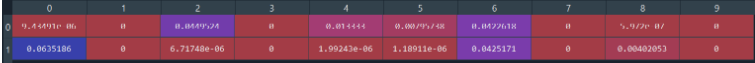

**Ds**\
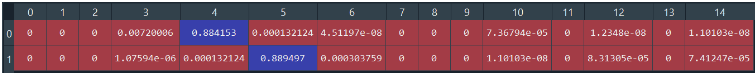

The steady state response is obtained when $C\cdot \theta' = 0$. 


In [ ]:
bT=np.array([10,10,10,20,20,20,10,10,10])
fQ=np.array([0,0,0,0,0,0])
u = np.hstack([bT, fQ])
print(f'u = {u}')

yss = (-Cs @ np.linalg.inv(As) @ Bs + Ds) @ u
print(f'yss = {yss} °C')

The steady-state value of the output of the state-space representation is found to be:

yss = [19.87525825 19.8737095 ] °C

using an input vector 

u = [10 10 10 20 20 20 10 10 10  0  0  0  0  0  0]

### Compare the results obtained for the system of Differential Algebraic Equations (DAE) with the results obtained for the state-space representation
To compare the results of the DAE system and state space representation, the error was found between the two values of temperature in the rooms. 
- Max error between DAE and state-space, room 1: 1.55e-03 °C
- Max error between DAE and state-space, room 2: 1.55e-03 °C

In [ ]:
print(f'Max error between DAE and state-space, room 1: \
{max(abs(θ[3] - yss)):.2e} °C')
print(f'Max error between DAE and state-space, room 2: \
{max(abs(θ[10] - yss)):.2e} °C')

It can be seen from these results that the methods produce very similar results, both of which are close to the desired indoor temperature of 20 degrees celsius.

# Step Response

### Time step and settling time calculation

The first stage was to calculate the time step and settling time for this system, using the eigenvalues of state matrix As. The maximum timestep is the maximum timestep that maintains numerical stability.

In [ ]:
#Dynamic simulation
λ = np.linalg.eig(As)[0]    # eigenvalues of matrix As
print('Time constants: \n', -1 / λ, 's \n')
print('2 x Time constants: \n', -2 / λ, 's \n')
dtmax = 2 * min(-1. / λ)
print(f'Maximum time step: {dtmax:.2f} s = {dtmax / 60:.2f} min')

# time step
dt = np.floor(dtmax / 60) * 20   # s
print(f'dt = {dt} s = {dt / 60:.0f} min')

# settling time
time_const = np.array([int(x) for x in sorted(-1 / λ)])
print('4 * Time constants: \n', 4 * time_const, 's \n')

t_settle = 4 * max(-1 / λ)
print(f'Settling time: \
{t_settle:.0f} s = \
{t_settle / 60:.1f} min = \
{t_settle / (3600):.2f} h = \
{t_settle / (3600 * 24):.2f} days')

Maximum time step: 261.74 s = 4.36 min\
For the rest of this programme, a time step of 1 min will be used as it is below the maximum and will allow the convergence of the system to a steady state to be observed.\
Settling time: 602830 s = 10047.2 min = 167.45 h = 6.98 days

### Input vector u and time integration

An input vector u was constructed using 10 degrees as the outdoor temperature, and 20 degrees for the indoor and HVAC temperatures.

From this calculated timestep, a timestep for the simulation could be set within the minimum, and a time integration performed using both the Euler implicit and explicit methods.

Initially, a timestep of 4 minutes was used (close to the maximum), however this resulted in a sharp spike at the beginning of the output response graph, and so the timestep was reduced to 1 minute to remove this effect.

In [ ]:
# Step response
# -------------
# Find the next multiple of 3600 s that is larger than t_settle
duration = np.ceil(t_settle / 3600) * 3600
n = int(np.floor(duration / dt))    # number of time steps
t = np.arange(0, n * dt, dt)        # time vector for n time steps

print(f'Duration = {duration} s')
print(f'Number of time steps = {n}')
# pd.DataFrame(t, columns=['time'])


#Input vector

u = np.zeros([15, n])                # u = [To To To Tisp Φo Φi Qa Φa]
u[0:3,:] = 10 * np.ones([3, n])    # To = 10 for n time steps
u[3:6,:] = 20 * np.ones([3, n])      # Tisp = 20 for n time steps
u[6:9, :] = 10 * np.ones([3, n])    # To = 10 for n time steps
print(u)

# pd.DataFrame(u)

#####################
#Time integration
n_s = As.shape[0]                      # number of state variables
θ_exp = np.zeros([n_s, t.shape[0]])    # explicit Euler in time t
θ_imp = np.zeros([n_s, t.shape[0]])    # implicit Euler in time t

I = np.eye(n_s)                        # identity matrix

for k in range(n - 1):
    θ_exp[:, k + 1] = (I + dt * As) @\
        θ_exp[:, k] + dt * Bs @ u[:, k]
    θ_imp[:, k + 1] = np.linalg.inv(I - dt * As) @\
        (θ_imp[:, k] + dt * Bs @ u[:, k])

#explicit and  implicit Euler methods
y_exp = Cs @ θ_exp + Ds @  u
y_imp = Cs @ θ_imp + Ds @  u
#Results and Plot
fig, ax = plt.subplots()
ax.plot(t / 3600, y_exp.T, t / 3600, y_imp.T)
ax.set(xlabel='Time, $t$ / h',
       ylabel='Temperatue, $θ_i$ / °C',
       title='Step input: outdoor temperature $T_o$')
ax.legend(['Explicit', 'Implicit'])
ax.grid()
plt.show()


### Plot the results

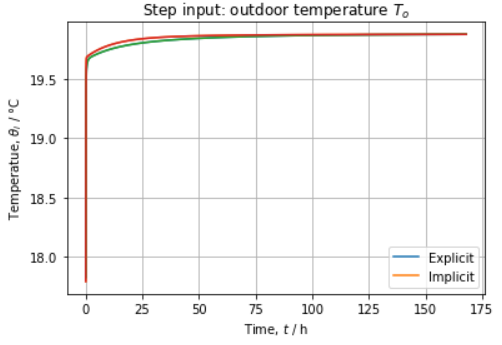

Steady-state response to step input: Room 1: 19.8732, Room 2: 19.8731 °C\
This result shows that the output temperatures (rooms 1 and 2) converge relatively quickly to a steady state value close to the desired temperature of 20 degrees, and close to the value obtained from the state-space calculations.Furthermore, it can be seen that the explicit and implicit Euler integrations for each room produce near identical results.

The steady state from these results (after around 60 seconds) can be compared to the previous DAE and state-space results.


In [ ]:
#The value the indoor temperature obtained after the settling time is almost equal to the value obtained in steady-state.
print('Steady-state indoor temperature obtained with:')
print(f'- DAE model: Room 1: {float(θ[3]):.4f}, Room 2: {float(θ[10]):.4f} °C')
print(f'- state-space model: Room 1: {float(yss[0]):.4f}, Room 2: {float(yss[1]):.4f} °C')
print(f'- steady-state response to step input: Room 1: {float(y_exp[0, -2]):.4f}, Room 2: {float(y_exp[1, -2]):.4f} °C')

# RESPONSE TO WEATHER

### Define start and end time
- 2000-01-03 12:00:00 	start date
- 2000-02-05 18:00:00 	end date

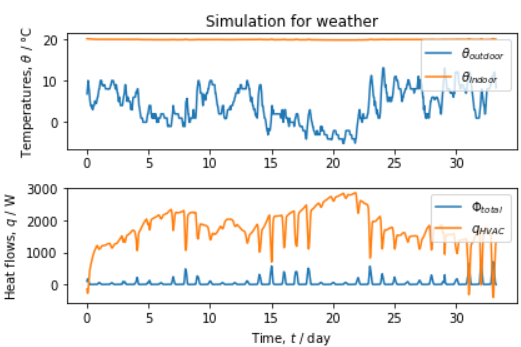

These results clearly show the effect of a change in outdoor temperature on the required heating in order to maintain the indoor temperature.When the outdoor temperature drops, an increase in q,HVAC can be seen, as more power is required to heat the rooms. 

In [ ]:
#Define start and end time.
start_date = '01-03 12:00:00'
end_date = '02-05 18:00:00'
start_date = '2000-' + start_date
end_date = '2000-' + end_date
print(f'{start_date} \tstart date')
print(f'{end_date} \tend date')

### Preparation of inputs
Weather data for Lyon in a .epw file was used as the data source, and was sample to identify the necessary values for the later calculations and simulations.\
The heat flux in each branch was calculated using estimates for the absorption and transmission coefficients for each surface.

In [ ]:
#Inputs
#Read weather data
filename = './weather_data/FRA_Lyon.074810_IWEC.epw'
[data, meta] = dm4bem.read_epw(filename, coerce_year=None)
weather = data[["temp_air", "dir_n_rad", "dif_h_rad"]]
del data

#select from the start to the end date:
weather.index = weather.index.map(lambda t: t.replace(year=2000))
weather = weather.loc[start_date:end_date]

#Solar irradiance on the walls
#calculate the: direct irradiance, W/m²,diffuse irradiance, W/m²,reflected irradiance, W/m²
surface_orientation = {'slope': 90,
                       'azimuth': 0,
                       'latitude': 45}
albedo = 0.2
rad_surf = dm4bem.sol_rad_tilt_surf(
    weather, surface_orientation, albedo)
# pd.DataFrame(rad_surf)

#total solar irradiance Etot
rad_surf['Φtot'] = rad_surf.sum(axis=1)

#Resample the weather data
data = pd.concat([weather['temp_air'], rad_surf['Φtot']], axis=1)
data = data.resample(str(dt) + 'S').interpolate(method='linear')
data = data.rename(columns={'temp_air': 'To'})
# pd.DataFrame(data)

#Other inputs
#consider indoor temperature Ti,sp=20∘C and the auxiliary heat flow Q˙a=0W
data['Ti'] = 20 * np.ones(data.shape[0])
data['Qa'] = 0 * np.ones(data.shape[0])
# pd.DataFrame(data)

#Input vector in time
# input vector
To = data['To']
Ti = data['Ti']
Φo1 = α_wSW * 18.85 * data['Φtot']
Φo2= α_wSW * 4.2 * data['Φtot']
Φa1=α_gSW * 2.5 * data['Φtot']
Φa2=α_gSW * 1.45 * data['Φtot']
Φi1 = τ_gSW * α_wSW * 2.5 * data['Φtot']
Φi2 = τ_gSW * α_wSW * 1.45 * data['Φtot']
Qa = data['Qa']
#Φa = α_gSW * glass_surface_sun * data['Φtot']

#Heat sources 4,7,8,11,12,15
u = pd.concat([To, To, To, Ti,Ti,Ti,To,To,To, Φo1, Φo2,Φi1,Φi2, Φa1, Φa2 ], axis=1)
u.columns.values[[9, 10, 11, 12, 13, 14]] = ['Φo1', 'Φo2','Φi1','Φi2', 'Φa1', 'Φa2']
# pd.DataFrame(u)

### Time integration

After defining the initial conditions, a time integration was performed.

In [ ]:
#Initial conditions
θ_exp = 20 * np.ones([As.shape[0], u.shape[0]])

#Time integration
for k in range(u.shape[0] - 1):
    θ_exp[:, k + 1] = (I + dt * As) @ θ_exp[:, k]\
        + dt * Bs @ u.iloc[k, :]

y_exp = Cs @ θ_exp + Ds @ u.to_numpy().T
q_HVAC = Kp * (data['Ti'] - y_exp[0, :])
data['θi_exp1'] = y_exp.T[:,0]
data['θi_exp2']=y_exp.T[:,1]
data['q_HVAC'] = q_HVAC.T

### Plotting results

In [ ]:
fig, axs = plt.subplots(2, 1)

data[['To', 'θi_exp1']].plot(ax=axs[0],
                            xticks=[],
                            ylabel='Temperature, $θ$ / °C')
axs[0].legend(['$θ_{outdoor}$', '$θ_{indoor}$'],
              loc='upper right')

data[['Φtot', 'q_HVAC']].plot(ax=axs[1],
                              ylabel='Heat rate, $q$ / W')
axs[1].set(xlabel='Time')
axs[1].legend(['$Φ_{total}$', '$q_{HVAC}$'],
             loc='upper right')
plt.show()

### Results
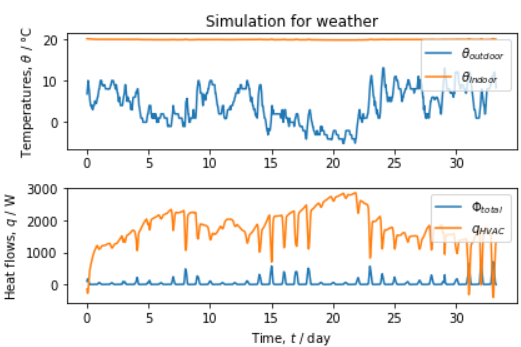

These results clearly show the effect of a change in outdoor temperature on the required heating in order to maintain the indoor temperature.When the outdoor temperature drops, an increase in qHVAC can be seen, as more power is required to heat the rooms. 


# Further analysis

To analyse the effect of different temperature and control scenarios on the system response, three further scenarios were simulated.

### Scenario 1

Increasing the time step to 240s, which is close but less than the maximum time step(261s) to assure stability, we can see that our system is still stable although we find some fluctuations in temperatures, and there is an initial sharp spike.

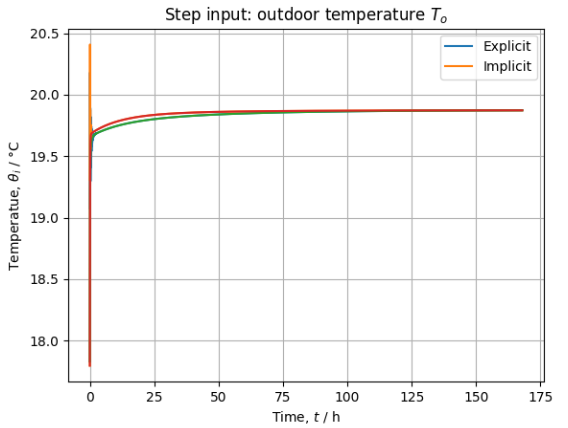

To prevent this and to reach our desired temperature precisely, we decrease our step time to 80 seconds.

### Scenario 2

Without a controller, the room temperature is never attaining our desired indoor temperature of 20°C since nothing is controlling it, so no HVAC system is working.

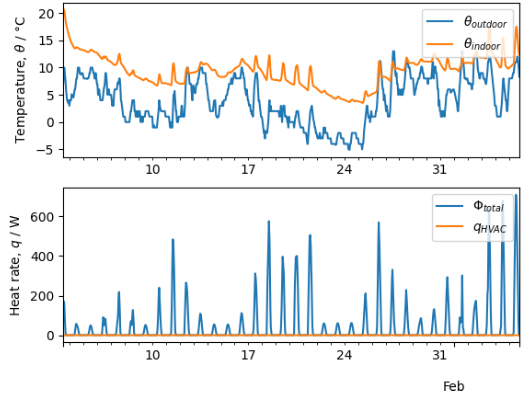

Since there is no control, indoor temperature follows the outside one but in a less percentage of fluctuations, since all walls are well insulated and heat flows to the inside are limited. 

### Scenario 3

If we double the insulation on the walls, and compare to the same date range (so same outside temperature) as before, heat rate q is not attaining 3kW anymore and the overall heat production by the HVAC system is reduced, while maintaining the inside temperature of 20°C.\ 
Increasing wall insulation can be a prudent choice. It improves energy efficiency, reduces utility bills, enhances indoor comfort, minimizes noise transfer, and contributes to sustainability. However we should be considering factors like the initial cost.

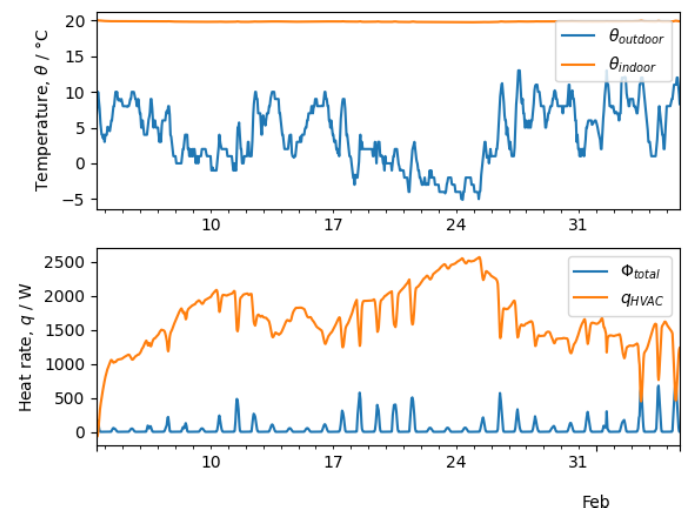

### Scenario 4

We took another date to simulate our model. We wanted to see the effect of having a very hot outside temperature on the behavior of our system, so we chose a range in summer from 1 June 2021 to the start of September 2021, since each year is getting hotter because of climate change.

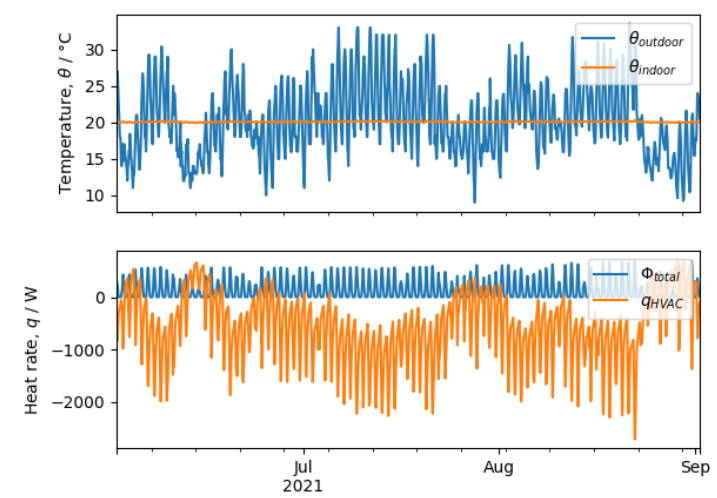

Controller is working as an air conditioner and the heat rate is negative because our HVAC system is removing heat from the inside and rejecting it to the outside. Through this, the temperature at the inside is kept at 20°C even though the outside temperature is higher than the desired temperature. Heat rate is working at 2kW sometimes, spending energy close to but not the same as in winter.

# Conclusion

In conclusion, this set of models and simulations has modelled heat transfer and energy management in a building. For the base scenario of 10 degrees outside and 20 degrees inside, it could be seen that the same steady state response was obtained from each model. The time taken to reach this steady state could be observed from the step response simulation, and using real weather data allowed the performance of the HVAC system to be analysed, and observation of the variation in temperature. Finally, alternative temperature and control scenarios were considered to analyse the effect on the output response.
